In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

import recova.learning_dataset
from recova.learning.learning import model_from_file
from recova.util import kullback_leibler, wishart_kl_divergence

np.set_printoptions(precision=3, linewidth=100)

In [3]:
DATASET_FILE = '/home/dlandry/dataset/learning_sets/2018-08-14-inside.json'
LEARNING_RUN_FILE = '/home/dlandry/dataset/learning_runs/2018-08-15-apartment.json'
MODEL_FILE = '/home/dlandry/dataset/learning_runs/2018-08-15-apartment.model'
CENSI_ESTIMATES_FILE = '/home/dlandry/dataset/censi_estimates/2018-08-15-apartment.json'

In [4]:
with open(DATASET_FILE) as f:
    dataset = json.load(f)
    
with open(LEARNING_RUN_FILE) as f:
    learning_run = json.load(f)

with open(CENSI_ESTIMATES_FILE) as f:
    censi_estimates = json.load(f)
    
model = model_from_file(MODEL_FILE, 'cello')

In [5]:
xs = np.array(dataset['data']['xs'])
ys = np.array(dataset['data']['ys'])


train_set = learning_run['train_set']
validation_set = learning_run['validation_set']

In [6]:
validation_xs = xs[validation_set]
validation_ys = ys[validation_set]

In [7]:
predictions = model.predict(validation_xs)
censi_predictions = np.array(censi_estimates['data']['censi_estimates'])

In [8]:
reference_norms = np.zeros(len(predictions))
prediction_norms = np.zeros(len(predictions))
norm_loss = np.zeros(len(predictions))
wishart_kl = np.zeros(len(predictions))
gaussian_kl = np.zeros(len(predictions))
percent_loss = np.zeros(len(predictions))
censi_loss = np.zeros(len(predictions))
censi_kl = np.zeros(len(predictions))

for i in range(len(predictions)):
    reference_norms[i] = np.linalg.norm(ys[validation_set[i]])
    prediction_norms[i] = np.linalg.norm(predictions[i])
    wishart_kl[i] = wishart_kl_divergence(ys[validation_set[i]], 6, predictions[i], 6)
    norm_loss[i] = np.linalg.norm(ys[validation_set[i]] - predictions[i])
    percent_loss = abs(norm_loss[i] / np.linalg.norm(ys[validation_set[i]]))
    gaussian_kl[i] = kullback_leibler(ys[validation_set[i]], predictions[i])
    
    censi_loss[i] = np.linalg.norm(ys[validation_set[i]] - censi_predictions[i])
    censi_kl[i] = kullback_leibler(ys[validation_set[i]], censi_predictions[i])
    
    print('{}: {}'.format(i, gaussian_kl[i]))

0: 10.300025082236516
1: 7.135034673382572
2: 19.641683562277823
3: 7.8583002768632575
4: 6.829766898058773
5: 14.460074107224017
6: 7.920002529977239
7: 3.9590091138312453
8: 3.2692169837678264
9: 3.603621526211053
10: 3.877837917139659
11: 3.9957375934043493
12: 3.9116737042828387
13: 3.591197700169806
14: 6.119602011613041
15: 5.951893672016459
16: 6.527929726663076
17: 7.351563063998283
18: 6.10765081998925
19: 5.964012501446458
20: 5.900351620707772
21: 3.390775840861821
22: 3.394388496494404
23: 3.1630282718141016
24: 3.4307397727840043
25: 3.2728474156828877
26: 3.016265944911786
27: 3.180618539054662
28: 4.314519025058
29: 4.395120230399417
30: 4.376959288574101
31: 4.3547803985668905
32: 4.394302176431928
33: 4.266566426473658
34: 4.206443523546131
35: 7.586531218244369
36: 7.631318567390085
37: 7.555711092878367
38: 7.4639407951648185
39: 7.538696676379429
40: 7.501561708320732
41: 7.45243541301854
42: 9487428.828578172
43: 9558933.258205328
44: 11181230.384606328
45: 9467378

/home/dlandry/repos/registration-covariance-analysis/recova/util.py:277: RuntimeWarning: invalid value encountered in log
  (scipy.special.multigammaln(prediction_degrees_of_freedom / 2., 6) - scipy.special.multigammaln(base_degress_of_freedom / 2., 6)) +
/home/dlandry/repos/registration-covariance-analysis/recova/util.py:277: RuntimeWarning: divide by zero encountered in log
  (scipy.special.multigammaln(prediction_degrees_of_freedom / 2., 6) - scipy.special.multigammaln(base_degress_of_freedom / 2., 6)) +



294: 303.13249655878127
295: 308.45235909448434
296: 303.5666883365225
297: 310.6582992801615
298: 328.92661070819446
299: 319.7883169299941
300: 341.89606235881604
301: 71.42365330842823
302: 72.6096523180695
303: 70.04653118242291
304: 78.52723544903154
305: 71.53619858297425
306: 79.74063734984088
307: 10.455380197974005
308: 11.200869307529802
309: 75.70646709665917
310: 10.78727925722513
311: 11.827885142950011
312: 10.826603474188932
313: 10.795182270510097
314: 10.672855370397494
315: 10.899325336384546
316: 11.021446319596853
317: 12.51647012991681
318: 10.985379745074685
319: 11.812643975628681
320: 12.399552101450295
321: 2314631.2503577406
322: 11.116282307128259
323: 2496405.6146267178
324: 2167080.3533523194
325: 2194097.753390862
326: 2271276.8376336317
327: 2395405.3939375
328: 2643502.540447853
329: 10.006317742519197
330: 10.55210417338099
331: 10.894440468476589
332: 10.89117288400173
333: 10.049335873360771
334: 10.396643747584854
335: 11.003893249308774
336: 6.5166

742: 489.7971015794026
743: 520.4989851508142
744: 501.3069392687714
745: 486.2401851354546
746: 569.0614089486594
747: 528.5058350138427
748: 609.6831915312158
749: 31.041584517434323
750: 29.678939003765457
751: 28.78542406498765
752: 33.20820421738029
753: 37.286717149367405
754: 41.22765391659678
755: 27.97220582352586
756: 18.044369028827685
757: 19.210831349581078
758: 16.993620053204204
759: 21.409465280570686
760: 17.865994424938926
761: 23.79565537602336
762: 18.606443773327378
763: 11.485659196336094
764: 11.443232357758735
765: 11.497634708893937
766: 11.541160202480008
767: 11.391992400609666
768: 11.408336925927497
769: 11.219239715919784
770: 1200.929667387142
771: 1157.9768950381904
772: 1145.260834342652
773: 1230.6032208036063
774: 1299.0721817350452
775: 1114.5802668729145
776: 1396.5305981163526
777: 260.5519708794775
778: 261.79926406554716
779: 262.54481717660394
780: 267.4842140742797
781: 261.13499655265366
782: 271.7510424249
783: 340.4636080213786
784: 2.553880

In [9]:
len(censi_predictions)

1190

In [10]:
gaussian_kl[123]

kullback_leibler(ys[validation_set[123]], predictions[i])

print(ys[validation_set[123]])
print(np.linalg.det(ys[validation_set[123]] + np.identity(6) * 1e-15))

[[ 2.293e-09  4.147e-11 -8.783e-10 -6.358e-11 -1.453e-10  8.373e-11]
 [ 4.147e-11  4.075e-10  8.985e-11 -2.871e-11 -4.389e-12 -2.080e-11]
 [-8.783e-10  8.985e-11  1.125e-09 -3.632e-12  6.446e-11 -5.106e-11]
 [-6.358e-11 -2.871e-11 -3.632e-12  3.039e-11  2.122e-11  5.191e-12]
 [-1.453e-10 -4.389e-12  6.446e-11  2.122e-11  7.061e-11 -3.802e-11]
 [ 8.373e-11 -2.080e-11 -5.106e-11  5.191e-12 -3.802e-11  4.882e-11]]
1.5312697876637546e-59


In [11]:
wishart_kl.mean()
np.median(wishart_kl)

/home/dlandry/.envs/recov/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


nan

In [12]:
print('Dataset: {}'.format(learning_run['metadata']['cross_validation']))
print('Avg. Norm loss: {:.2E}'.format(norm_loss.mean()))
print('Avg. Percent loss: {:.2E}'.format(percent_loss.mean()))
print('Avg. Wishart KL loss: {:.2E}'.format(wishart_kl.mean()))
print('Avg. Gaussian KL loss: {:.1f}'.format(gaussian_kl.mean()))
print('Avg. Censi Loss: {:.2E}'.format(censi_loss.mean()))
print('Avg. Censi Gaussian KL loss: {:1f}'.format(censi_kl.mean()))
print('N Pairs: {}'.format(len(predictions)))

Dataset: apartment
Avg. Norm loss: 4.46E-02
Avg. Percent loss: 2.17E+01
Avg. Wishart KL loss: NAN
Avg. Gaussian KL loss: 902152.0
Avg. Censi Loss: 4.46E-02
Avg. Censi Gaussian KL loss: 82642179.785823
N Pairs: 1190


<IPython.core.display.Javascript object>


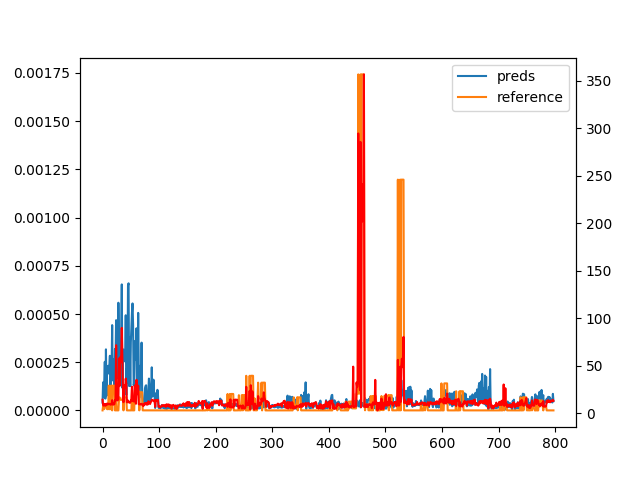

In [153]:
plt.plot(list(range(len(predictions))), prediction_norms, label='preds')
plt.plot(list(range(len(predictions))), reference_norms, label='reference')
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()

ax2.plot(list(range(len(predictions))), gaussian_kl, color='red')
plt.show()


In [154]:
gaussian_kl.max()

356.92773546121566

In [155]:
p = predictions[750]
ref = ys[validation_set[750]]

In [156]:
wishart_kl_divergence(ref, 6, p, 6)

48.25836441657843

In [157]:
p

array([[ 9.315e-06,  9.474e-06, -4.592e-07, -5.550e-08, -1.555e-07, -7.397e-06],
       [ 9.474e-06,  2.716e-05, -6.682e-08,  3.349e-07, -1.969e-07, -1.046e-05],
       [-4.592e-07, -6.682e-08,  3.194e-07,  5.701e-08,  7.650e-08,  5.669e-07],
       [-5.550e-08,  3.349e-07,  5.701e-08,  3.711e-08,  1.390e-08,  1.343e-07],
       [-1.555e-07, -1.969e-07,  7.650e-08,  1.390e-08,  2.693e-08,  2.685e-07],
       [-7.397e-06, -1.046e-05,  5.669e-07,  1.343e-07,  2.685e-07,  9.780e-06]], dtype=float32)

In [158]:
ref

array([[ 2.873e-07,  4.066e-08, -8.408e-10,  1.719e-09, -9.746e-09, -2.908e-08],
       [ 4.066e-08,  6.292e-08,  2.010e-09,  3.029e-09, -1.364e-09, -2.919e-08],
       [-8.408e-10,  2.010e-09,  2.002e-08, -4.771e-10,  6.634e-09, -9.793e-10],
       [ 1.719e-09,  3.029e-09, -4.771e-10,  1.054e-09, -1.566e-10, -2.501e-09],
       [-9.746e-09, -1.364e-09,  6.634e-09, -1.566e-10,  4.295e-09,  1.686e-09],
       [-2.908e-08, -2.919e-08, -9.793e-10, -2.501e-09,  1.686e-09,  2.997e-08]])

In [159]:
p - ref

array([[ 9.027e-06,  9.434e-06, -4.584e-07, -5.722e-08, -1.458e-07, -7.368e-06],
       [ 9.434e-06,  2.710e-05, -6.883e-08,  3.319e-07, -1.955e-07, -1.043e-05],
       [-4.584e-07, -6.883e-08,  2.994e-07,  5.749e-08,  6.987e-08,  5.679e-07],
       [-5.722e-08,  3.319e-07,  5.749e-08,  3.606e-08,  1.405e-08,  1.368e-07],
       [-1.458e-07, -1.955e-07,  6.987e-08,  1.405e-08,  2.263e-08,  2.668e-07],
       [-7.368e-06, -1.043e-05,  5.679e-07,  1.368e-07,  2.668e-07,  9.750e-06]])

In [19]:
(p - ref) / ref

array([[  45.246,  -49.617,  -41.373,  354.195,   17.398, 1013.192],
       [ -49.617,  166.112,   20.533, 4487.762,   59.994,  267.657],
       [ -41.373,   20.533,   18.271,  107.208,  128.516, -808.717],
       [ 354.195, 4487.762,  107.208, 1301.63 ,   18.507,  128.135],
       [  17.398,   59.994,  128.516,   18.507,  148.023, -107.148],
       [1013.192,  267.657, -808.717,  128.135, -107.148, 1077.038]])